## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [12]:
# Import libraries and dependencies
import os
import pandas as pd
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

In [13]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

Python-dotenv could not parse statement starting at line 1


True

In [14]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [15]:
# Set timeframe to "1Day"
timeframe = "1Day"

# Set start and end datetimes between now and 4 years ago.
start_date = pd.Timestamp("2017-05-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-05-01", tz="America/New_York").isoformat()

# Set the ticker information
tickers = ["T","NKE","XOM"]

# Get 4 year's worth of historical price data
# HINT: Set "limit" to at least 10000 so all ticker rows are captured from get_bars()
df_ticker = api.get_bars(
    tickers,
    timeframe,
    start=start_date,
    end=end_date
).df

# Display sample data
df_ticker

,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2017-05-01 04:00:00+00:00,55.40,55.450,54.98,54.99,4881442,30491,55.201737,NKE
2017-05-02 04:00:00+00:00,55.16,55.160,54.79,55.07,7363885,41589,54.967165,NKE
2017-05-03 04:00:00+00:00,55.17,55.300,54.40,54.53,9486619,48477,54.622933,NKE
2017-05-04 04:00:00+00:00,54.69,54.830,54.20,54.47,6830628,39260,54.501544,NKE
2017-05-05 04:00:00+00:00,54.49,54.500,53.56,53.95,13379949,57959,53.889567,NKE
...,...,...,...,...,...,...,...,...
2021-04-26 04:00:00+00:00,55.54,56.285,55.44,55.68,16034091,92919,55.853625,XOM
2021-04-27 04:00:00+00:00,55.98,56.630,55.81,56.41,19125056,115395,56.197130,XOM
2021-04-28 04:00:00+00:00,56.86,58.460,56.79,58.11,24647373,150114,58.000608,XOM


> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [16]:
# Reorganize the DataFrame
# Separate ticker data
T = df_ticker[df_ticker["symbol"]=="T"].drop("symbol", axis=1)
NKE = df_ticker[df_ticker["symbol"]=="NKE"].drop("symbol", axis=1)
XOM = df_ticker[df_ticker["symbol"]=="XOM"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
df_ticker = pd.concat([T, NKE, XOM], axis=1, keys=["T","NKE","XOM"])

# Display sample data
df_ticker

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.37  31.38  30.89  30.91  45360916      135223   
2021-04-27 04:00:00+00:00  30.80  30.88  30.63  30.77  33200088      123035   
2021-04-28 04:00:00+00:00  31.00  31.15  30.90  30.96  27960327      105456   
2021-04-29 04:00:00+00:00  31.14  31.53  31.11  31.34  37758789      129297   
2021-04-30 04:00:00+00:00  31.41  31.43  31.05  31.41  31132760      103024   

                                         NKE                   ...            \
                                vwap    open    high      low  ...    volume   
timestamp                                                      ...             
2017-05-01 04:00:00+00:00  39.278779   55.40   55.45   54.980  ...   4881442   
2017-05-02 04:00:00+00:00  38.996448   55.16   55.16   54.790  ...   7363885   
2017-05-03 04:00:00+00:00  38.423685   55.17   55.30   54.400  ...   9486619   
2017-05-04 04:00:00+00:00  37.965109   54.69   54.83   54.200  ...   6830628   
2017-05-05 04:00:00+00:00  38.424403   54.49   54.50   53.560  ...  13379949   
...                              ...     ...     ...      ...  ...       ...   
2021-04-26 04:00:00+00:00  31.027616  130.49  131.70  129.320  ...   8190144   
2021-04-27 04:00:00+00:00  30.742178  132.00  132.79  131.410  ...   5809799   
2021-04-28 04:00:00+00:00  31.009157  132.51  132.29  130.345  ...   8020322   
2021-04-29 04:00:00+00:00  31.320009  131.77  134.12  131.250  ...   6536005   
2021-04-30 04:00:00+00:00  31.287630  132.44  133.88  132.050  ...   5608876   

                                                     XOM                  \
                          trade_count        vwap   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00       30491   55.201737  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00       41589   54.967165  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00       48477   54.622933  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00       39260   54.501544  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00       57959   53.889567  81.63  82.2350  81.61   
...                               ...         ...    ...      ...    ...   
2021-04-26 04:00:00+00:00       82720  130.887296  55.54  56.2850  55.44   
2021-04-27 04:00:00+00:00       67270  132.160411  55.98  56.6300  55.81   
2021-04-28 04:00:00+00:00       81372  130.802962  56.86  58.4600  56.79   
2021-04-29 04:00:00+00:00       81782  132.969621  58.90  59.4800  58.15   
2021-04-30 04:00:00+00:00       62735  132.817825  58.24  58.8900  57.16   

                                                                   
                           close    volume trade_count       vwap  
timestamp                                                          
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657  
...                          ...       ...         ...        ...  
2021-04-26 04:00:00+00:00  55.68  16034091       92919  55.853625  
2021-04-27 04:00:00+00:00  56.41  19125056      115395  56

### Simulate five year portfolio growth with evenly-distributed stock investments

In [17]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
MC_five_year = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.30, .30, .40],
    num_simulation = 500,
    num_trading_days = 252*5
)

# Print the simulation input data
MC_five_year.portfolio_data

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   
...                          ...    ...    ...    ...       ...         ...   
2021-04-26 04:00:00+00:00  31.37  31.38  30.89  30.91  45360916      135223   
2021-04-27 04:00:00+00:00  30.80  30.88  30.63  30.77  33200088      123035   
2021-04-28 04:00:00+00:00  31.00  31.15  30.90  30.96  27960327      105456   
2021-04-29 04:00:00+00:00  31.14  31.53  31.11  31.34  37758789      129297   
2021-04-30 04:00:00+00:00  31.41  31.43  31.05  31.41  31132760      103024   

                                                      NKE          ...  \
                                vwap daily_return    open    high  ...   
timestamp                                                          ...   
2017-05-01 04:00:00+00:00  39.278779          NaN   55.40   55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836   55.16   55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121   55.17   55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156   54.69   54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470   54.49   54.50  ...   
...                              ...          ...     ...     ...  ...   
2021-04-26 04:00:00+00:00  31.027616    -0.015605  130.49  131.70  ...   
2021-04-27 04:00:00+00:00  30.742178    -0.004529  132.00  132.79  ...   
2021-04-28 04:00:00+00:00  31.009157     0.006175  132.51  132.29  ...   
2021-04-29 04:00:00+00:00  31.320009     0.012274  131.77  134.12  ...   
2021-04-30 04:00:00+00:00  31.287630     0.002234  132.44  133.88  ...   

                                                      XOM                  \
                                 vwap daily_return   open     high    low   
timestamp                                                                   
2017-05-01 04:00:00+00:00   55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00   54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00   54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00   54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00   53.889567    -0.009547  81.63  82.2350  81.61   
...                               ...          ...    ...      ...    ...   
2021-04-26 04:00:00+00:00  130.887296     0.010830  55.54  56.2850  55.44   
2021-04-27 04:00:00+00:00  132.160411     0.003875  55.98  56.6300  55.81   
2021-04-28 04:00:00+00:00  130.802962    -0.010597  56.86  58.4600  56.79   
2021-04-29 04:00:00+00:00  132.969621     0.019509  58.90  59.4800  58.15   
2021-04-30 04:00:00+00:00  132.817825    -0.004803  58.24  58.8900  57.16   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  
...                          ...       ...         ...        ...          ...  
2021-04-26 04:00:00+00:00  55.68  16034091       92919  55.853625     0.001979 

In [18]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\minha\OneDrive\Documents\ASU_2022_Bootcamp\Activity_Files\05-APIs\3\Activities\04-Stu_Three_Stock_Monte\Unsolved\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.993654,0.995856,0.992200,0.999590,1.000683,1.023393,1.002121,0.992709,0.984263,0.994974,...,0.986109,0.987315,1.006569,0.992782,1.018266,1.012399,0.990457,1.004430,0.996212,1.003278
2,1.006516,1.000382,1.003635,1.011322,1.006390,1.024167,1.005503,0.975805,0.998523,1.005920,...,0.990917,0.992685,0.991493,1.006776,1.012654,1.029397,0.983188,1.010250,0.989760,0.998698
3,0.984154,0.988710,1.012230,1.018253,1.036667,0.999864,1.016378,0.977548,0.994939,0.981843,...,0.982931,1.003852,0.985825,1.009799,1.015420,1.040316,0.979867,1.002200,0.983538,1.006659
4,0.979230,0.994901,1.021635,1.017547,1.067118,0.985864,1.014215,0.961121,0.975200,0.977275,...,0.973357,1.009569,0.990962,1.002693,1.024249,1.049930,0.989415,1.001783,0.991306,1.005018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.016031,0.971984,1.997238,1.085654,0.744454,1.887649,0.987163,1.990619,1.235862,2.351935,...,1.776225,0.690402,1.873204,1.336948,0.821934,1.881882,0.912923,1.463109,1.760258,0.847354
1257,1.008937,0.958527,2.002124,1.095356,0.764164,1.881440,0.999704,1.990924,1.222304,2.328171,...,1.769415,0.689592,1.884864,1.332930,0.835117,1.868260,0.916303,1.444763,1.774760,0.849787
1258,1.010176,0.955845,1.995278,1.098828,0.757529,1.879969,0.994905,1.954110,1.196932,2.347466,...,1.755437,0.688692,1.893823,1.334873,0.839109,1.853370,0.909854,1.460587,1.774364,0.853298
1259,1.016732,0.953484,1.988115,1.103261,0.773210,1.857087,0.981132,1.934645,1.185294,2.347206,...,1.731218,0.690847,1.915918,1.348539,0.852929,1.879527,0.913467,1.438252,1.776317,0.859046


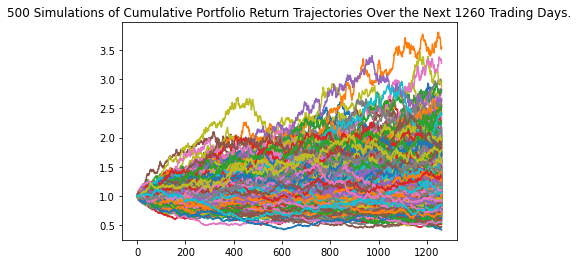

In [19]:
# Plot simulation outcomes
line_plot = MC_five_year.plot_simulation()
line_plot.get_figure().savefig("MC_fiveyear_sim_plot.png", bbox_inches="tight")

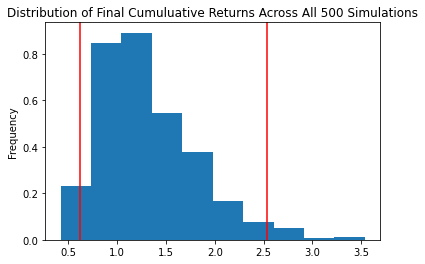

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_five_year.plot_distribution()
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png',bbox_inches='tight') 

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_five_year.summarize_cumulative_return()

# Print summary statistics
print(tbl) 

count           500.000000
mean              1.311497
std               0.494121
min               0.418546
25%               0.944701
50%               1.233922
75%               1.582103
max               3.538462
95% CI Lower      0.618804
95% CI Upper      2.540010
Name: 1260, dtype: float64


In [22]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $10,000 in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $10,000 in the portfolio over the next 5 years will end within in the range of $6188.04 and $25400.1


### Simulate five year portfolio growth with 60% AT&T stock

In [23]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_att = MCSimulation(
    portfolio_data = df_ticker,
    weights = [.60, .40, .20],
    num_simulation = 500,
    num_trading_days = 252*5
)
# Print the simulation input data
MC_att.portfolio_data.head()

T                                             \
                            open   high    low  close    volume trade_count   
timestamp                                                                     
2017-05-01 04:00:00+00:00  39.69  39.70  39.06  39.10  24750447       95238   
2017-05-02 04:00:00+00:00  39.15  39.22  38.88  38.95  24852467       86237   
2017-05-03 04:00:00+00:00  38.94  38.98  38.15  38.40  33743554      113920   
2017-05-04 04:00:00+00:00  38.38  38.41  37.63  38.01  31450002      118191   
2017-05-05 04:00:00+00:00  38.06  38.71  38.03  38.56  21829853       82070   

                                                     NKE         ...  \
                                vwap daily_return   open   high  ...   
timestamp                                                        ...   
2017-05-01 04:00:00+00:00  39.278779          NaN  55.40  55.45  ...   
2017-05-02 04:00:00+00:00  38.996448    -0.003836  55.16  55.16  ...   
2017-05-03 04:00:00+00:00  38.423685    -0.014121  55.17  55.30  ...   
2017-05-04 04:00:00+00:00  37.965109    -0.010156  54.69  54.83  ...   
2017-05-05 04:00:00+00:00  38.424403     0.014470  54.49  54.50  ...   

                                                     XOM                  \
                                vwap daily_return   open     high    low   
timestamp                                                                  
2017-05-01 04:00:00+00:00  55.201737          NaN  81.56  82.2100  81.48   
2017-05-02 04:00:00+00:00  54.967165     0.001455  82.17  82.5900  81.90   
2017-05-03 04:00:00+00:00  54.622933    -0.009806  81.97  83.0699  81.91   
2017-05-04 04:00:00+00:00  54.501544    -0.001100  82.28  82.3600  81.40   
2017-05-05 04:00:00+00:00  53.889567    -0.009547  81.63  82.2350  81.61   

                                                                                
                           close    volume trade_count       vwap daily_return  
timestamp                                                                       
2017-05-01 04:00:00+00:00  82.06   8664579       49226  81.941004          NaN  
2017-05-02 04:00:00+00:00  82.05   9102893       54234  82.197909    -0.000122  
2017-05-03 04:00:00+00:00  82.70  10289447       57309  82.625679     0.007922  
2017-05-04 04:00:00+00:00  81.64  16165093       86289  81.729800    -0.012817  
2017-05-05 04:00:00+00:00  82.02  10212004       59397  81.932657     0.004655  

[5 rows x 24 columns]

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Simulate five year portfolio growth with 60% Nike stock

In [ ]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

# Printing the simulation input data
MC_nike.portfolio_data.head()

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Simulate five year portfolio growth with 60% Exxon stock

In [ ]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
# YOUR CODE HERE!

# Printing the simulation input data
MC_exxon.portfolio_data

In [ ]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
# YOUR CODE HERE!

In [ ]:
# Plot simulation outcomes
# YOUR CODE HERE!

In [ ]:
# Plot probability distribution and confidence intervals
# YOUR CODE HERE!

In [ ]:
# Fetch summary statistics from the Monte Carlo simulation results
# YOUR CODE HERE!

# Print summary statistics
# YOUR CODE HERE!

In [ ]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
# YOUR CODE HERE!

# Print results
# YOUR CODE HERE!

### Summarize findings across all 4 simulations

YOUR ANSWER HERE!